# Alarm Analysis: Software Versions 16.50 vs. 16.20
*Aviad Baram*

This notebook compares alarm data from infusion pumps running software versions 16.20 and 16.50. The goal is to assess the impact of the 16.50 release on alarm frequency and distribution, and to evaluate any changes in the rate of failed infusion treatments.

## Setup
1. Import required libraries
2. Define static variables for data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Data Paths

Set environment variables and generate file paths for the source data.

In [2]:
data_path = os.getenv('SHARED_DATA_PATH')  # env variable for data storage
us_treatment_data_path = os.path.join(data_path, r'alarm_analysis\sapphire_treatments_last_2_years_us.csv')
eu_treatment_data_path = os.path.join(data_path, r"alarm_analysis\sapphire_treatments_last_2_years_eu.csv")
cols_to_read = ['accountProviderID', 'serial_number', 'startTime', 'last_software_update', 'current_software_version', 'startTime', 'endTime', 'delivery_mode',
                'vi', 'vtbiExpected', 'total_alarms', 'alarm_codes']


## Data Preprocessing
1. Import raw treatment data for EU and US customers
2. Set data types
3. Remove rows with missing or corrupt values

### Data Import
Read and concatenate US and EU treatment data into a single DataFrame.

In [3]:
eu_treatment_df = pd.read_csv(eu_treatment_data_path, usecols=cols_to_read)
eu_treatment_df['region'] = 'EU'  # Add a new column to indicate the region
us_treatment_df = pd.read_csv(us_treatment_data_path, usecols=cols_to_read)
us_treatment_df['region'] = 'US'  
df = pd.concat([us_treatment_df, eu_treatment_df], ignore_index=True)
display(df.head(5))
raw_rows = df.shape[0]

,accountProviderID,serial_number,last_software_update,current_software_version,startTime,endTime,delivery_mode,vi,vtbiExpected,total_alarms,alarm_codes,region
0,Quantify Remote Care,300361744,2025-01-11 23:39:40.770158+00,16.20.12,2024-11-21 15:13:25+00,2024-11-21 15:16:27+00,Continuous,12.000000,10.0,1,40.0.0.0,US
1,Quantify Remote Care,300361744,2025-01-11 23:39:40.770158+00,16.20.12,2024-11-21 15:17:42+00,2024-11-21 15:17:50+00,Continuous,13.000000,10.0,0,NaN,US
2,Quantify Remote Care,300361744,2025-01-11 23:39:40.770158+00,16.20.12,2024-11-21 15:18:08+00,2024-11-21 15:18:15+00,Continuous,14.000000,10.0,0,NaN,US
3,Quantify Remote Care,300361744,2025-01-11 23:39:40.770158+00,16.20.12,2024-11-21 15:18:33+00,2024-11-21 15:18:48+00,Continuous,15.000000,10.0,0,NaN,US
4,Quantify Remote Care,300386779,2024-11-22 14:50:07.336146+00,16.20.12,2024-11-22 20:49:35+00,2024-11-22 21:19:45+00,Continuous,12.069444,12.5,0,NaN,US


In [4]:
raw_rows

266282

In [5]:
df['delivery_mode'].unique()  # Check unique delivery modes

array(['Continuous', 'Multistep', 'Taper', 'PCA', 'Intermittent',
       'EpiduralIntermittent', 'EpiduralPCA'], dtype=object)

### Data Cleaning
1. Convert columns to datetime and remove rows with missing or invalid values.
2. Remove rows that are from Avoset

In [6]:
df['last_software_update'] = pd.to_datetime(df['last_software_update'], errors='coerce')
df['startTime'] = pd.to_datetime(df['startTime'], errors='coerce')
df['endTime'] = pd.to_datetime(df['endTime'], errors='coerce')
na_rows = df[['last_software_update', 'startTime']].isna().any(axis=1)
num_na = na_rows.sum()
df = df[~na_rows]
avoset_rows = df['serial_number'].str.startswith('A')
num_avoset = avoset_rows.sum()  
df = df[~avoset_rows]
print(f"Dropping {num_na + num_avoset} rows from Avoset or with NaT values in 'last_software_update' or 'startTime' columns.")
print(f"Recovery: {100 * (df.shape[0]/raw_rows):.2f}%")

raw_pumps_num = df['serial_number'].nunique()
num_treatments = df.shape[0]
print("Raw data:")
print(f"Total pumps in the dataset: {raw_pumps_num}")
print(f"Total treatments in the dataset: {num_treatments}")

Dropping 69952 rows from Avoset or with NaT values in 'last_software_update' or 'startTime' columns.
Recovery: 73.73%
Raw data:
Total pumps in the dataset: 1636
Total treatments in the dataset: 196330


## Software Version Assignment
Assign software versions to treatments and pumps based on the last software update. Only treatments after the last recorded software update are included for each version.

### Version Assignment Details
Treatments are assigned a software version if their start time is after the last recorded software update. Treatments before the update are excluded due to ambiguity.

In [7]:
# get all treatments for tools with v16.20 after update time
df_20_idx = df.loc[(df['current_software_version'].str.startswith('16.20')) & 
                            (df['startTime'] >= df['last_software_update'])].index
# get all treatments for tools with v16.50 after update time
df_50_idx = df.loc[(df['current_software_version'].str.startswith('16.50')) & 
                            (df['startTime'] >= df['last_software_update'])].index
print(f"Treatments verified with 16.20: {len(df_20_idx)}")
print(f"Treatments verified with 16.50: {len(df_50_idx)}")
all_infusions = len(df_20_idx) + len(df_50_idx)
print(f"Total treatments with 16.20 or 16.50 software events: {all_infusions}")
print(f"Treatment recovery: {100 * all_infusions/num_treatments:.2f}%")

Treatments verified with 16.20: 30094
Treatments verified with 16.50: 9607
Total treatments with 16.20 or 16.50 software events: 39701
Treatment recovery: 20.22%


In [8]:
df_20_serials = df.loc[df_20_idx, 'serial_number'].unique()
df_50_serials = df.loc[df_50_idx, 'serial_number'].unique()
print(f"Pumps with 16.20 software events: {len(df_20_serials)}")
print(f"Pumps with 16.50 software events: {len(df_50_serials)}")
all_serials = np.concatenate([df_20_serials, df_50_serials])
print(f"Total pumps with 16.20 or 16.50 software events: {len(all_serials)}")
print(f"Pumps recovery: {100 * len(all_serials)/raw_pumps_num:.2f}%")

Pumps with 16.20 software events: 733
Pumps with 16.50 software events: 323
Total pumps with 16.20 or 16.50 software events: 1056
Pumps recovery: 64.55%


### Inferred Parameters

Set a threshold variable identifying treatments that were not completed.

In [9]:
COMPLETION_THRESHOLD = 0.90  # Define your threshold here

Calculate the treatments duration (in minutes) and the completion ratio [0.0 - 1.0].

Assign a stopped column if the completion ratio TH was not reached and there were alarms.

In [10]:

df['duration'] = (df['endTime'] - df['startTime']).dt.total_seconds() / 60  # duration in minutes
df['completion'] = df['vi'] / df['vtbiExpected']  # completion ratio
df['stopped'] = (df['completion'] < COMPLETION_THRESHOLD) & (~df['alarm_codes'].isna())

**Note:**

The recovery rate for treatments and pumps is limited by the availability of software upgrade records. Older treatments without upgrade history cannot be assigned a version.

### Data Overview for Graphs
Prepare weekly and version-based summaries for plotting.

C:\Users\aviad.baram\AppData\Local\Temp\ipykernel_17788\487172851.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  plot_df['week'] = df['startTime'].dt.to_period('W').apply(lambda r: r.start_time)


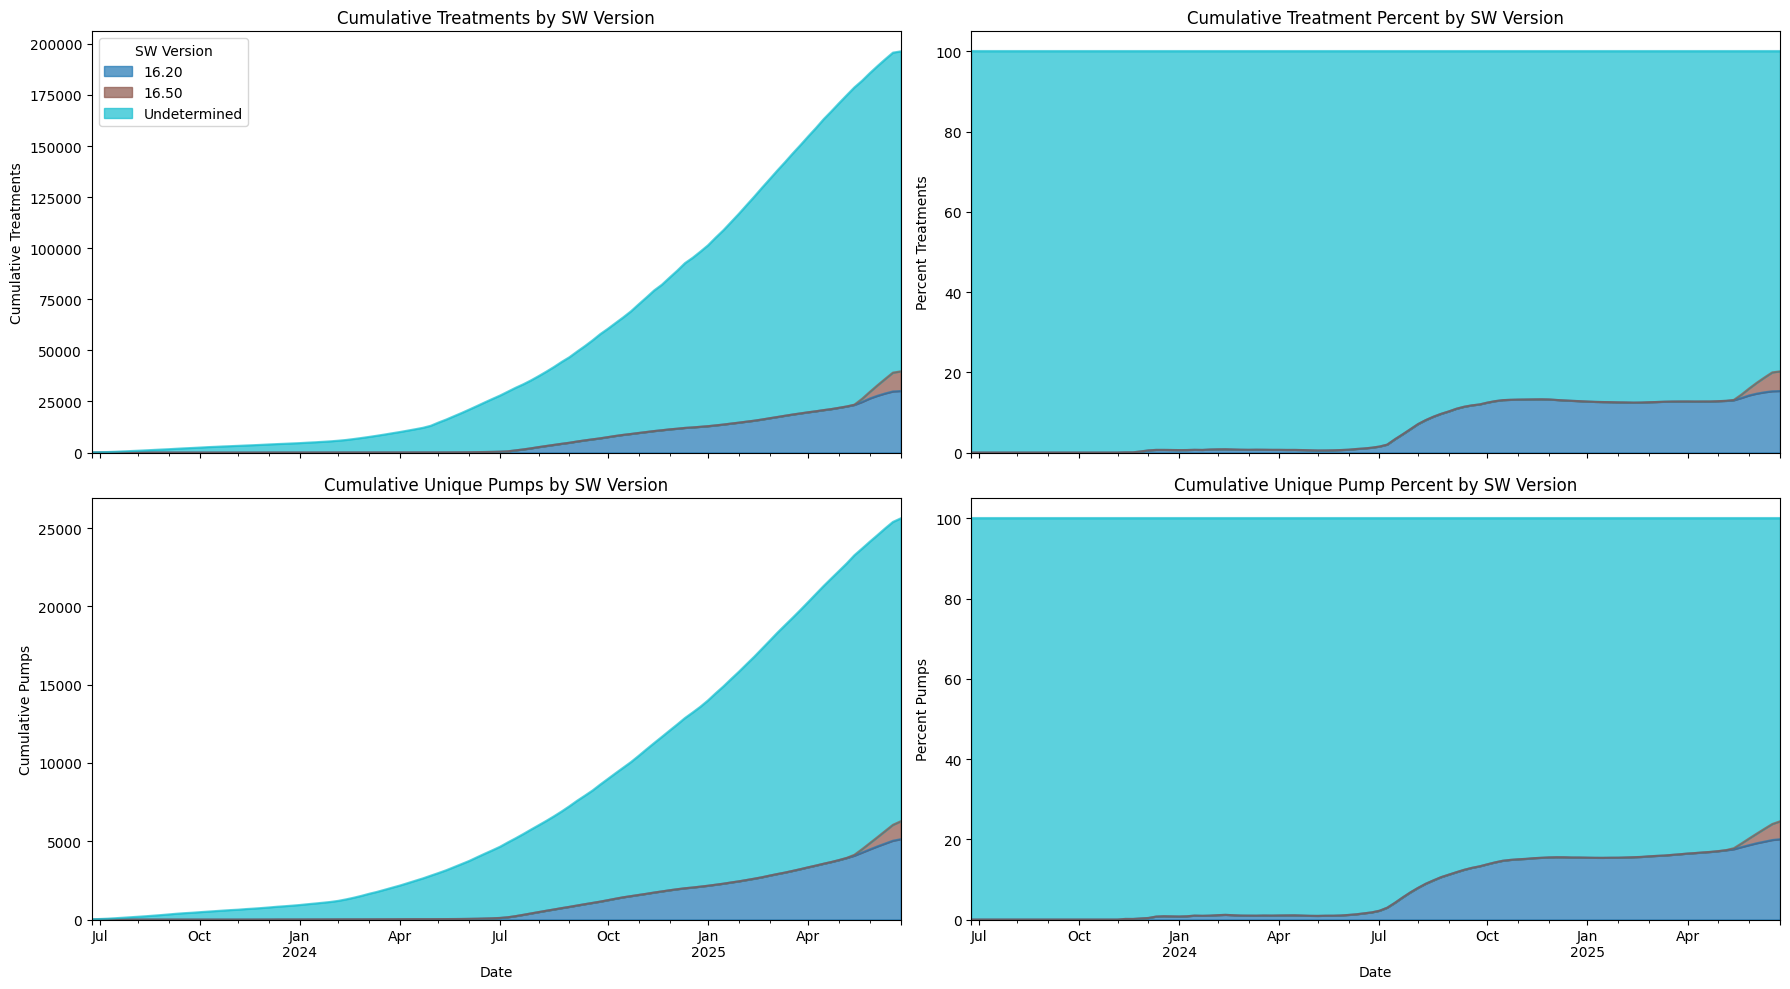

In [11]:
# Calculate cumulative unique pump counts by week and SW version
plot_df = pd.DataFrame(index=df.index, columns=['week', 'SW version', 'serial_number'])
plot_df = df.copy()  # for debugging
plot_df['SW version'] = 'Undetermined'
plot_df['serial_number'] = df['serial_number']
plot_df['week'] = df['startTime'].dt.to_period('W').apply(lambda r: r.start_time)
plot_df.loc[df_20_idx, 'SW version'] = '16.20'
plot_df.loc[df_50_idx, 'SW version'] = '16.50'

# Group by week and SW version, count treatments (rows)
treatment_counts = plot_df.groupby(['week', 'SW version']).size().unstack(fill_value=0)
cum_count_df = treatment_counts.cumsum()
cum_percent_df = cum_count_df.div(cum_count_df.sum(axis=1), axis=0).fillna(0) * 100
# Group by week and SW version, count unique serials
unique_serials = plot_df.groupby(['week', 'SW version'])['serial_number'].nunique().unstack(fill_value=0)
cum_unique_serials = unique_serials.cumsum()
cum_unique_percent = cum_unique_serials.div(cum_unique_serials.sum(axis=1), axis=0).fillna(0) * 100
# Prepare 4 subplots: top - treatments, bottom - pumps
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
# Top left: cumulative treatment count (already calculated above as cum_count_df)
cum_count_df.plot.area(ax=axes[0,0], colormap='tab10', alpha=0.7, legend=True)
axes[0,0].set_ylabel('Cumulative Treatments')
axes[0,0].set_xlabel('Date')
axes[0,0].set_title('Cumulative Treatments by SW Version')
# Top right: cumulative treatment percent
cum_percent_df.plot.area(ax=axes[0,1], colormap='tab10', alpha=0.7, legend=False)
axes[0,1].set_ylabel('Percent Treatments')
axes[0,1].set_xlabel('Date')
axes[0,1].set_title('Cumulative Treatment Percent by SW Version')
# Bottom left: cumulative unique pumps
cum_unique_serials.plot.area(ax=axes[1,0], colormap='tab10', alpha=0.7, legend=False)
axes[1,0].set_ylabel('Cumulative Pumps')
axes[1,0].set_xlabel('Date')
axes[1,0].set_title('Cumulative Unique Pumps by SW Version')
# Bottom right: cumulative unique pumps percent
cum_unique_percent.plot.area(ax=axes[1,1], colormap='tab10', alpha=0.7, legend=False)
axes[1,1].set_ylabel('Percent Pumps')
axes[1,1].set_xlabel('Date')
axes[1,1].set_title('Cumulative Unique Pump Percent by SW Version')
# Place legend only on the bottom right subplot
handles, labels = axes[0,0].get_legend_handles_labels()
axes[0,0].legend(handles, labels, loc='upper left', title='SW Version')
plt.tight_layout()

In [12]:
# keep only rows with SW version
assigned_indices = plot_df.loc[plot_df['SW version'] != 'Undetermined'].index
df = df.loc[assigned_indices]

In [ ]:
# save for other worksheets
# df.to_csv(os.path.join(data_path, r"titration_of_rate\treatment_version.csv"), index=False)

## Alarm Analysis
1. Parse alarm code arrays and count occurrences
2. Summarize alarm counts by type
3. Visualize alarm count and probability distributions

In [9]:
# Flatten all alarm_codes comma-delimited strings and get unique values
all_codes = []
for codes_str in df['alarm_codes'].dropna():
    codes = [c.strip() for c in codes_str.split(',') if c.strip()]
    all_codes.extend(codes)
unique_alarm_codes = set(all_codes)
alarms_df = pd.DataFrame(index=df.index, columns=list(unique_alarm_codes))
# Assign for each index the number of occurrences of each alarm
for idx, codes_str in df['alarm_codes'].items():
    if pd.isna(codes_str):
        alarms_df.loc[idx] = 0
        continue
    codes = [c.strip() for c in codes_str.split(',') if c.strip()]
    code_counts = pd.Series(codes).value_counts()
    for alarm in unique_alarm_codes:
        alarms_df.at[idx, alarm] = code_counts.get(alarm, 0)
alarms_df = alarms_df.fillna(0).astype(int)
alarms_df['version'] = plot_df['SW version']

C:\Users\aviad.baram\AppData\Local\Temp\ipykernel_22076\3348644365.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  alarms_df = alarms_df.fillna(0).astype(int)


### Alarm Code Mapping
Create a human-readable mapping from alarm codes to descriptions.

In [10]:
code_lookup_table = {
    '7.0.0.0': 'Upstream Occlusion',
    '9.0.0.0': 'Downstream Occlusion',
    '10.0.0.0': 'Administration set misplaced',
    '12.0.0.0': 'Air in Line',
    '13.0.0.0': 'Faulty air Detector',
    '16.0.0.0': 'Door open',
    '26.0.0.0': 'Low voltage for current rate',
    '29.0.0.0': 'Delayed KVO',
    '40.0.0.0': 'Accumulated Air in Line',
    '126.0.0.0': 'Delivery mode changed to',
    '129.0.0.0': 'Check for Occlusion',
    '152.0.0.0': 'No motor movement',
    '280.0.0.0': 'Potential Air in Line',
}

### Alarm Distribution Visualization
Generate side-by-side pie charts to compare alarm distributions between software versions.

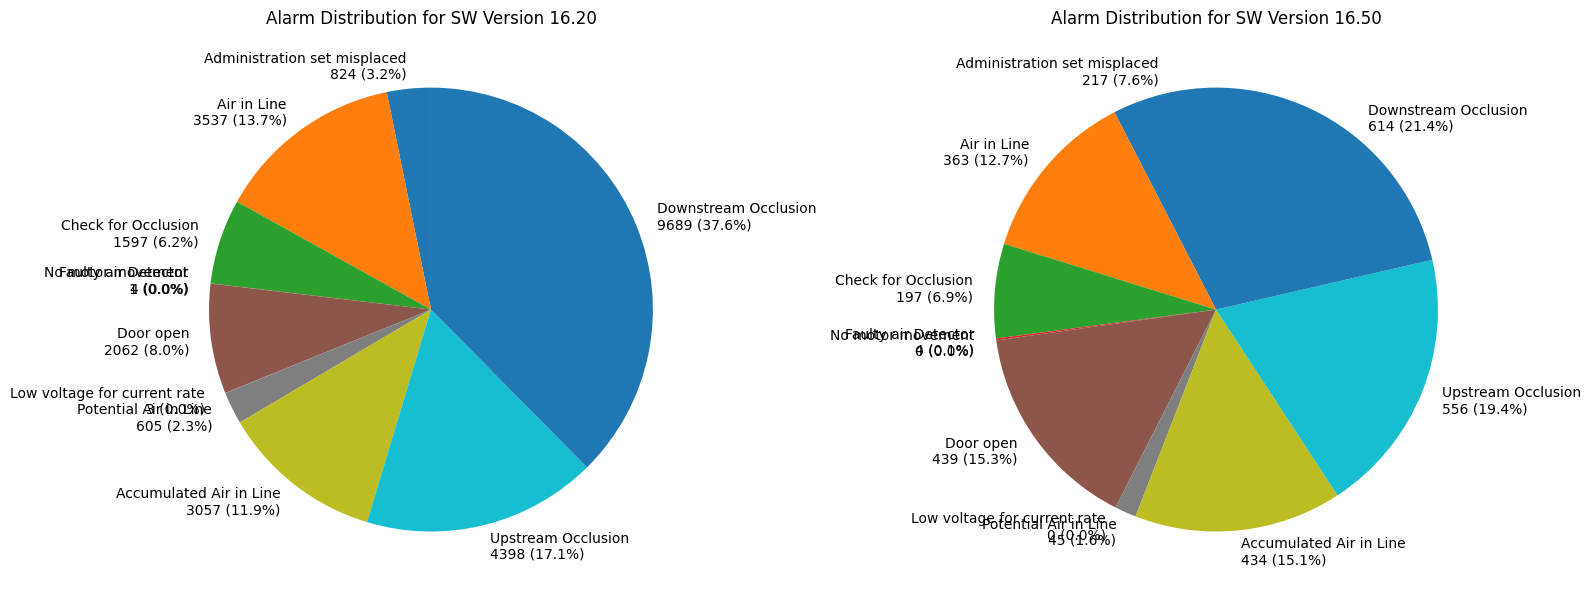

In [13]:
# Pie chart for alarm distribution by version, and generate DataFrame with absolute and probability values
results = []
# Get all unique alarm codes (sorted for consistent color mapping)
all_alarm_codes = sorted(set([r['alarm_code'] for r in results] + list(alarms_df.columns.drop('version'))))
# Use a fixed color palette (tab10 or tab20, depending on number of alarms)
palette = sns.color_palette(n_colors=len(all_alarm_codes))
color_map = {alarm: palette[i % len(palette)] for i, alarm in enumerate(all_alarm_codes)}

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for i, version in enumerate(['16.20', '16.50']):
    version_alarms = alarms_df[alarms_df['version'] == version].drop('version', axis=1)
    alarm_counts = version_alarms.sum().reindex(all_alarm_codes, fill_value=0)
    n_treatments = version_alarms.shape[0]
    alarm_probs = (version_alarms > 0).sum(axis=0) / n_treatments
    # Store results for DataFrame
    for alarm in alarm_counts.index:
        results.append({
            'alarm_code': alarm,
            'version': version,
            'absolute_count': alarm_counts[alarm],
            'probability': alarm_probs.get(alarm, 0)
        })
    labels = [f"{code_lookup_table.get(alarm, alarm)}\n{count} ({count / alarm_counts.sum() * 100:.1f}%)" for alarm, count in zip(alarm_counts.index, alarm_counts.values)]
    axes[i].pie(alarm_counts, labels=labels, autopct=None, startangle=90, colors=[color_map[alarm] for alarm in alarm_counts.index])
    axes[i].set_title(f"Alarm Distribution for SW Version {version}")
plt.tight_layout()
plt.show()

In [23]:
alarms_df.head()

,152.0.0.0,129.0.0.0,280.0.0.0,10.0.0.0,9.0.0.0,40.0.0.0,26.0.0.0,7.0.0.0,16.0.0.0,12.0.0.0,13.0.0.0,version
4,0,0,0,0,0,0,0,0,0,0,0,16.20
5,0,0,0,0,0,0,0,0,0,0,0,16.20
6,0,0,0,0,0,0,0,0,0,0,0,16.20
7,0,0,0,0,0,0,0,0,0,0,0,16.20
8,0,0,0,0,0,0,0,0,0,0,0,16.20


In [ ]:
    version_alarms = alarms_df[alarms_df['version'] == version].drop('version', axis=1)
    alarm_counts = version_alarms.sum().reindex(all_alarm_codes, fill_value=0)
    n_treatments = version_alarms.shape[0]
    alarm_probs = (version_alarms > 0).sum(axis=0) / n_treatments
    # Store results for DataFrame
    for alarm in alarm_counts.index:
        results.append({
            'alarm_code': alarm,
            'version': version,
            'absolute_count': alarm_counts[alarm],
            'probability': alarm_probs.get(alarm, 0)
        })
    labels = [f"{code_lookup_table.get(alarm, alarm)}\n{count} ({count / alarm_counts.sum() * 100:.1f}%)" for alarm, count in zip(alarm_counts.index, alarm_counts.values)]
    axes[i].pie(alarm_counts, labels=labels, autopct=None, startangle=90, colors=[color_map[alarm] for alarm in alarm_counts.index])
    axes[i].set_title(f"Alarm Distribution for SW Version {version}")


prob_df = prob_df.sort_values(by=['16.20', '16.50'], ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
width = 0.35
x = np.arange(len(prob_df.index))
ax.bar(x - width/2, prob_df['16.20'], width, label='16.20', color='tab:blue')
ax.bar(x + width/2, prob_df['16.50'], width, label='16.50', color='tab:orange')
ax.set_xticks(x)
ax.set_xticklabels([code_lookup_table[x] for x in prob_df.index], rotation=45, ha='right')
ax.set_ylabel('Probability of Alarm per Treatment')
ax.set_title('Probability of Each Alarm by Software Version')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# Create DataFrame from results and unstack by version
results_df = pd.DataFrame(results)
results_unstacked = results_df.pivot(index='alarm_code', columns='version', values=['absolute_count', 'probability'])
results_unstacked.index = results_unstacked.index.map(code_lookup_table)  # Map alarm codes to names
results_unstacked.index.name = 'alarm'
results_unstacked.columns = [' '.join((col[0].replace('_', ' '), col[1])).strip() for col in results_unstacked.columns.values]
results_unstacked['absolute count 16.20'] = results_unstacked['absolute count 16.20'].astype(int)
results_unstacked['absolute count 16.50'] = results_unstacked['absolute count 16.50'].astype(int)
for col in ['probability 16.20', 'probability 16.50']:
    results_unstacked[col] = results_unstacked[col].apply(lambda x: f"{x:.4f}")
results_unstacked = results_unstacked.sort_values('absolute count 16.20', ascending=False)
display(results_unstacked)

,absolute count 16.20,absolute count 16.50,probability 16.20,probability 16.50
alarm,,,,
Downstream Occlusion,9689,614,0.1206,0.0316
Upstream Occlusion,4398,556,0.0979,0.0475
Air in Line,3537,363,0.0674,0.0166
Accumulated Air in Line,3057,434,0.0519,0.0350
Door open,2062,439,0.0495,0.0336
Check for Occlusion,1597,197,0.0331,0.0150
Administration set misplaced,824,217,0.0248,0.0221
Potential Air in Line,605,45,0.0124,0.0027
Faulty air Detector,4,4,0.0001,0.0004


### Alarm Probability Comparison
Compare the probability of each alarm type between software versions 16.20 and 16.50.

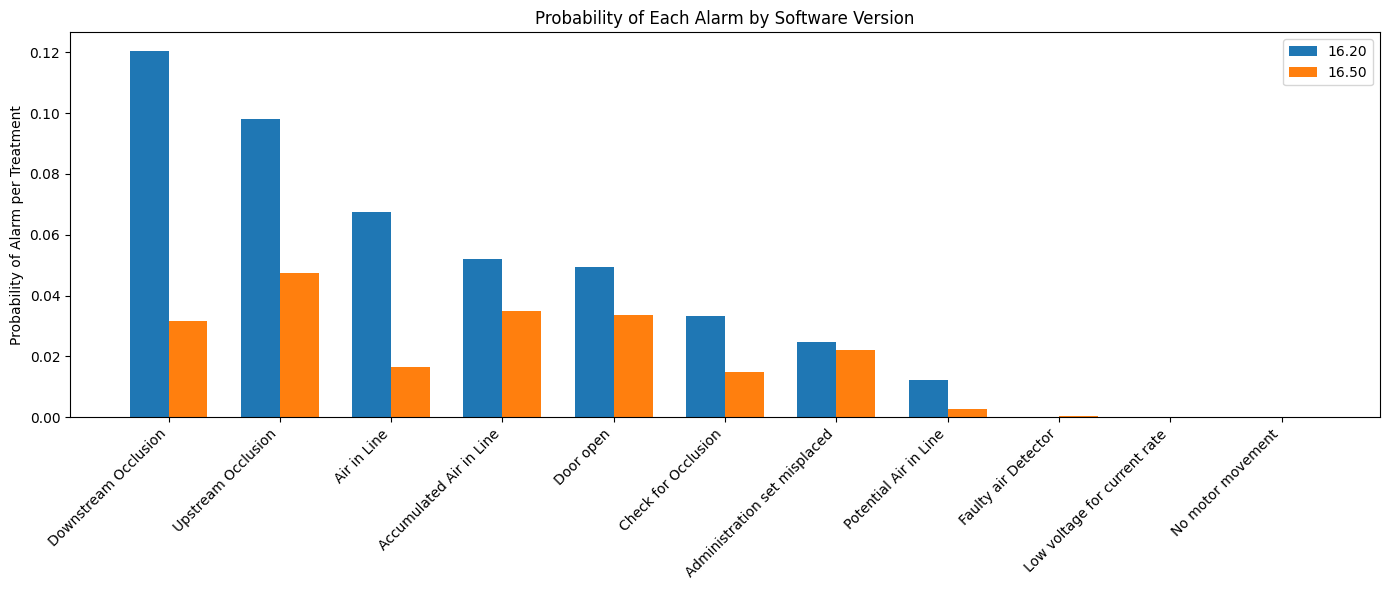

In [16]:
# Calculate alarm probabilities for each version
alarm_probs = []
for version in ['16.20', '16.50']:
    version_alarms = alarms_df[alarms_df['version'] == version].drop('version', axis=1)
    n_treatments = version_alarms.shape[0]
    # For each alarm, count number of treatments where it appears at least once
    alarm_treatment_counts = (version_alarms > 0).sum(axis=0)
    alarm_prob = alarm_treatment_counts / n_treatments
    alarm_probs.append(alarm_prob.rename(version))
alarm_probs_df = pd.DataFrame(alarm_probs).T
alarm_probs_df = alarm_probs_df.sort_index()
# Bar plot: probability of each alarm by version
# Probability = number of treatments with that alarm / total treatments for that version
prob_df = pd.DataFrame(index=alarms_df.columns.drop('version'))
for version in ['16.20', '16.50']:
    version_alarms = alarms_df[alarms_df['version'] == version].drop('version', axis=1)
    # A treatment is counted as having an alarm if it appears at least once
    prob_df[version] = (version_alarms > 0).sum(axis=0) / version_alarms.shape[0]

prob_df = prob_df.sort_values(by=['16.20', '16.50'], ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
width = 0.35
x = np.arange(len(prob_df.index))
ax.bar(x - width/2, prob_df['16.20'], width, label='16.20', color='tab:blue')
ax.bar(x + width/2, prob_df['16.50'], width, label='16.50', color='tab:orange')
ax.set_xticks(x)
ax.set_xticklabels([code_lookup_table[x] for x in prob_df.index], rotation=45, ha='right')
ax.set_ylabel('Probability of Alarm per Treatment')
ax.set_title('Probability of Each Alarm by Software Version')
ax.legend()
plt.tight_layout()
plt.show()

In [20]:
display_alarms = alarm_probs_df.copy()
display_alarms.index = [code_lookup_table[x] for x in alarm_probs_df.index]
display_alarms['16.20'] = display_alarms['16.20'].apply(lambda x: f"{x:.4f}")
display_alarms['16.50'] = display_alarms['16.50'].apply(lambda x: f"{x:.4f}")
display(display_alarms)

,16.20,16.50
Administration set misplaced,0.0248,0.0221
Air in Line,0.0674,0.0166
Check for Occlusion,0.0331,0.0150
Faulty air Detector,0.0001,0.0004
No motor movement,0.0000,0.0000
Door open,0.0495,0.0336
Low voltage for current rate,0.0001,0.0000
Potential Air in Line,0.0124,0.0027
Accumulated Air in Line,0.0519,0.0350
Upstream Occlusion,0.0979,0.0475


## Conclusions & Next Steps

### Key Findings

1. For all alarm types analyzed, the probability of occurrence is lower in pumps running software version 16.50 compared to those running version 16.20.

### Next steps

1. Alarm number in treatment distribution
2. distribution by treatment type
3. Alarm correlation
4. Increase the number of infusions and pumps analyzed by incorporating pump version update history.
5. Verify all required alarms have been analyzed